In [1]:
import uproot
import numpy as np 
import wc_helper
import mplhep as hep
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq, fftshift, ifft
from scipy.signal import savgol_filter
from tqdm import tqdm

In [2]:
file = uproot.open("sbnd-data-check.root")
# file.keys()

In [3]:
gaus_sigma = 0.1 
def gaussian_filter(f,a):
    """
    Parameters
    ----------
    f : array_like
        The input array.
    a : float
        The sigma of the gaussian filter.
    
    Returns
    -------
    array_like
        The filtered array.
    """
    return np.where(f!=0, np.exp(-0.5*(abs(f)/a)**2),0)
    # return np.exp(-0.5*(abs(f)/a)**2)

In [4]:
plane = "u"
ch_num= 1006

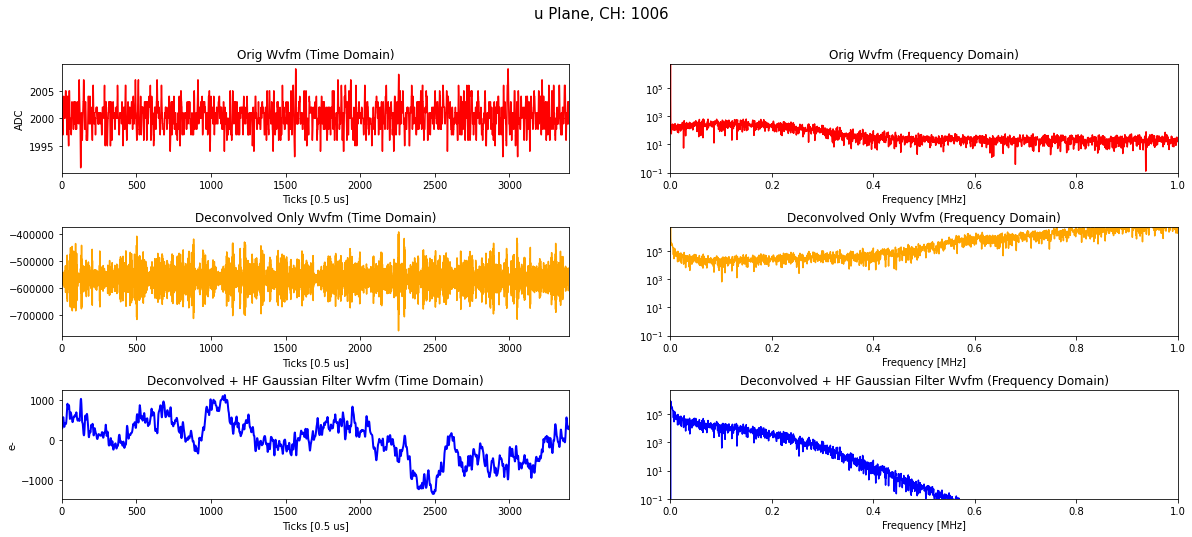

In [5]:
fig, axes = plt.subplots(3,2,figsize=(20,8))
plt.subplots_adjust(hspace=0.5)
xmin = 0
xmax = 3399

tk = file["h"+plane+"_decon_2D_init0"].to_numpy()[2][:-1] # ticks 

# orig wvfm
orig_mask = np.where(np.ceil(file["h"+plane+"_orig0;1"].to_numpy()[1])==ch_num)[0][0]
orig_adc = file["h"+plane+"_orig0;1"].to_numpy()[0][orig_mask]
axes[0][0].plot(tk,orig_adc,color="red")
axes[0][0].set_title("Orig Wvfm (Time Domain)")
axes[0][0].set_xlabel("Ticks [0.5 us]")
axes[0][0].set_xlim(xmin,xmax)
axes[0][0].set_ylabel("ADC")
orig_xf = fftfreq(orig_adc.size,0.5)
orig_yf = fft(orig_adc)
axes[0][1].plot(fftshift(orig_xf),fftshift(abs(orig_yf)),color="red")
axes[0][1].set_xlim(0,1)
axes[0][1].set_yscale("log")
axes[0][1].set_ylim(1e-1,5e6)
axes[0][1].set_title("Orig Wvfm (Frequency Domain)")
axes[0][1].set_xlabel("Frequency [MHz]")

# deconvolved wvfm
dec_mask = np.where(np.ceil(file["h"+plane+"_decon_2D_init0;1"].to_numpy()[1])==ch_num)[0][0]
dec_adc = file["h"+plane+"_decon_2D_init0;1"].to_numpy()[0][dec_mask]
axes[1][0].plot(tk,dec_adc,color="orange")
axes[1][0].set_title("Deconvolved Only Wvfm (Time Domain)")
axes[1][0].set_xlabel("Ticks [0.5 us]")
axes[1][0].set_xlim(xmin,xmax)
dec_xf = fftfreq(dec_adc.size,0.5)
dec_yf = fft(dec_adc)
axes[1][1].plot(fftshift(dec_xf),fftshift(abs(dec_yf)),color="orange")
axes[1][1].set_xlim(0,1)
axes[1][1].set_ylim(1e-1,5e6)
axes[1][1].set_yscale("log")
axes[1][1].set_title("Deconvolved Only Wvfm (Frequency Domain)")
axes[1][1].set_xlabel("Frequency [MHz]")

# gaussian filtered wvfm 
axes[2][0].plot(tk,(ifft(gaussian_filter(dec_xf,gaus_sigma)*dec_yf).real),lw=2,color="blue")
axes[2][0].set_title("Deconvolved + HF Gaussian Filter Wvfm (Time Domain)")
axes[2][0].set_xlabel("Ticks [0.5 us]")
axes[2][0].set_xlim(xmin,xmax)
axes[2][0].set_ylabel("e-")
axes[2][1].plot(fftshift(dec_xf),fftshift(abs(gaussian_filter(dec_xf,gaus_sigma)*dec_yf)),color="blue")
axes[2][1].set_xlim(0,1.0)
axes[2][1].set_ylim(1e-1,5e6)
axes[2][1].set_yscale("log")
axes[2][1].set_title("Deconvolved + HF Gaussian Filter Wvfm (Frequency Domain)")
axes[2][1].set_xlabel("Frequency [MHz]")

plt.suptitle(plane+" Plane, CH: "+str(ch_num),fontsize=15)
plt.show()


In [6]:
# roi_array = np.logspace(0.95,2.95,100,dtype=int)
roi_array = np.linspace(8,800,198*2,dtype=int)

In [7]:
# roi_array= np.array([100])

# mean 
roi_mean = np.zeros((3, len(roi_array)))
slc_mean = np.zeros((3, len(roi_array)))

# median
roi_medi = np.zeros((3, len(roi_array)))
slc_medi = np.zeros((3, len(roi_array)))

# standard deviation 
roi_reso = np.zeros((3, len(roi_array)))
slc_reso = np.zeros((3, len(roi_array)))

# quartile resolution 
roi_quar = np.zeros((3, len(roi_array)))
slc_quar = np.zeros((3, len(roi_array)))

for iplane in range(3):
    if iplane==0: plane = "u"
    if iplane==1: plane = "v"
    if iplane==2: plane = "w"
    for i, ROI_length in enumerate(tqdm(roi_array)):
        roi_charge_arr = []
        slc_charge_arr = []
        for iteration in range(int(250)):
            if iplane==0: ch_num = np.random.randint(0,wc_helper.idx_v0)
            if iplane==1: ch_num = np.random.randint(wc_helper.idx_v0,wc_helper.idx_w0)
            if iplane==2: ch_num = np.random.randint(wc_helper.idx_w0,wc_helper.idx_u1)
            dec_mask = np.where(np.ceil(file["h"+plane+"_decon_2D_init0;1"].to_numpy()[1])==ch_num)[0][0]
            adc = file["h"+plane+"_decon_2D_init0"].to_numpy()[0][dec_mask]
        
            # FFT into frequency domain 
            xf = fftfreq(adc.size,0.5)
            yf = fft(adc)
            wvfm = (ifft(gaussian_filter(xf,gaus_sigma)*yf)).real
            
            # subtract the pedestal of the wvfm
            # don't need if the baseline is removed in the gaussian filter 
            # wvfm = wvfm - np.median(wvfm) 
            
            # randomly obtain an ROI window 
            beg_tk = np.random.randint(0,3400-ROI_length)
            end_tk = beg_tk + ROI_length
                
            # get the wvfm snippets using the given ROI 
            wvfm_smp = wvfm[beg_tk:end_tk]
            tk_smp = tk[beg_tk:end_tk]
            
            # subtract the **linear** baseline of the wvfm ROI, induction planes only
            if plane!="w":
                slope = (wvfm_smp[-1]-wvfm_smp[0])/(tk_smp[-1]-tk_smp[0])
                baseline_smp = slope*tk_smp + wvfm_smp[0] - slope*tk_smp[0]
                wvfm_smp = wvfm_smp - baseline_smp
            # roi_charge = np.sum(wvfm_smp[wvfm_smp>0])
            roi_charge = np.sum(wvfm_smp)
            roi_charge_arr.append(roi_charge)

            # obtain the "central" time slice, time slices are 4 ticks width
            slc = tk_smp[::4] # start:stop:step, sample the wvfm every 4 ticks 
            slc_central = slc[int(len(slc)/2)]
            # get the index of the central time slice inside the ROI window 
            tk_central = np.where(tk_smp==slc_central)[0][0] 
            slc_smp = wvfm_smp[int(tk_central):int(tk_central+4)]
            slc_charge = np.sum(slc_smp)
            slc_charge_arr.append(slc_charge)
        # recast arrays into numpy arrays
        roi_charge_arr = np.array(roi_charge_arr)
        slc_charge_arr = np.array(slc_charge_arr)
        
        # get the mean of the charge distribution
        roi_mean[iplane,i] = np.mean(roi_charge_arr)
        slc_mean[iplane,i] = np.mean(slc_charge_arr)
        
        # get the median of the charge distribution
        roi_medi[iplane,i] = np.median(roi_charge_arr)
        slc_medi[iplane,i] = np.median(slc_charge_arr)
        
        # get the standard deviation of the charge distribution
        roi_reso[iplane,i] = np.std(roi_charge_arr)
        slc_reso[iplane,i] = np.std(slc_charge_arr)
        
        roi_quar[iplane,i] = wc_helper.quartile_reso(roi_charge_arr)
        slc_quar[iplane,i] = wc_helper.quartile_reso(slc_charge_arr)

  0%|          | 0/396 [00:00<?, ?it/s]

100%|██████████| 396/396 [02:06<00:00,  3.14it/s]


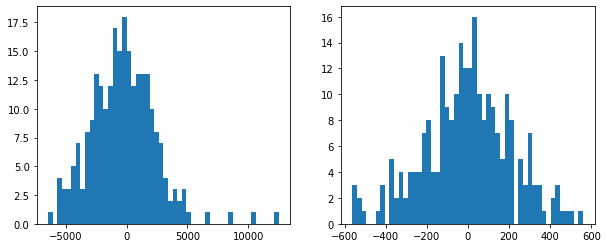

In [8]:
fig, axes = plt.subplots(1,2,figsize=(10,4))
axes[0].hist(roi_charge_arr,bins=50)
axes[1].hist(slc_charge_arr,bins=50)
plt.show()

In [9]:
# read csv file 
uboone_roi_u = np.loadtxt("uboone_roi_u.csv",delimiter=",")
uboone_roi_v = np.loadtxt("uboone_roi_v.csv",delimiter=",")
uboone_roi_w = np.loadtxt("uboone_roi_w.csv",delimiter=",")

uboone_slc_u = np.loadtxt("uboone_slc_u.csv",delimiter=",")
uboone_slc_v = np.loadtxt("uboone_slc_v.csv",delimiter=",")
uboone_slc_w = np.loadtxt("uboone_slc_w.csv",delimiter=",")

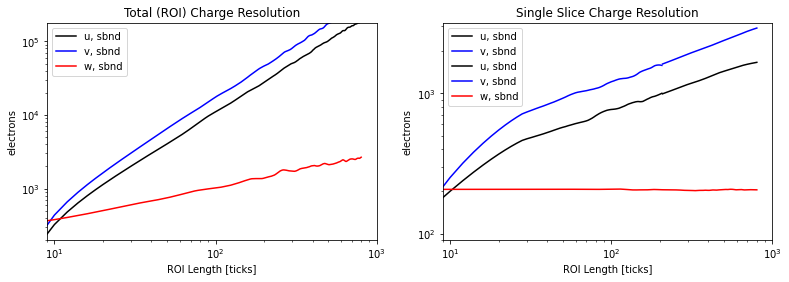

In [60]:
ind_window = 21
ind_order = 2

col_window = 15
col_order = 1

fig, axes = plt.subplots(1,2,figsize=(13,4))
plt.subplots_adjust(hspace=0.6)
# axes[0].plot(roi_array,roi_reso[0],alpha=0.5,label="u",color="black")
# axes[0].plot(roi_array,roi_reso[1],alpha=0.5,label="v",color="blue")
# axes[0].plot(roi_array,roi_reso[2],alpha=0.5,label="w",color="red")
# axes[0].plot(uboone_roi_u[:,0],uboone_roi_u[:,1],"--",alpha=0.5,color="black",label="u, uboone")
# axes[0].plot(uboone_roi_v[:,0],uboone_roi_v[:,1],"--",alpha=0.5,color="blue",label="v, uboone")
# axes[0].plot(uboone_roi_w[:,0],uboone_roi_w[:,1],"--",alpha=0.5,color="red",label="w, uboone")
roi_reso_u_sf = savgol_filter(savgol_filter(roi_reso[0], ind_window, ind_order),21,2)
roi_reso_v_sf = savgol_filter(savgol_filter(roi_reso[1], ind_window, ind_order),21,2)
roi_reso_w_sf = savgol_filter(savgol_filter(roi_reso[2], col_window, col_order),21,2)
axes[0].plot(roi_array,roi_reso_u_sf,label="u, sbnd",color="black")
axes[0].plot(roi_array,roi_reso_v_sf,label="v, sbnd",color="blue")
axes[0].plot(roi_array,roi_reso_w_sf,label="w, sbnd",color="red")
axes[0].legend()
axes[0].set_xscale("log")
axes[0].set_yscale("log")
axes[0].set_title("Total (ROI) Charge Resolution")
axes[0].set_xlabel("ROI Length [ticks]")
axes[0].set_ylabel("electrons")
axes[0].set_xlim(9,1e3)
axes[0].set_ylim(200,1.8e5)

col_window = 51
col_order = 0
# axes[1].plot(roi_array,slc_reso[0],alpha=0.5,label="u",color="black")
# axes[1].plot(roi_array,slc_reso[1],alpha=0.5,label="v",color="blue")
# axes[1].plot(roi_array,slc_reso[2],alpha=0.5,label="w",color="red")
# axes[1].plot(uboone_slc_u[:,0],uboone_slc_u[:,1],"--",alpha=0.5,color="black",label="u, uboone")
# axes[1].plot(uboone_slc_v[:,0],uboone_slc_v[:,1],"--",alpha=0.5,color="blue",label="v, uboone")
# axes[1].plot(uboone_slc_w[:,0],uboone_slc_w[:,1],"--",alpha=0.5,color="red",label="w, uboone")
slc_reso_u_sf = savgol_filter(savgol_filter(slc_reso[0], ind_window, ind_order),21,2)
slc_reso_v_sf = savgol_filter(savgol_filter(slc_reso[1], ind_window, ind_order),21,2)
slc_reso_w_sf = savgol_filter(savgol_filter(slc_reso[2], col_window, col_order),21,2)
axes[1].plot(roi_array[:100],savgol_filter(savgol_filter(slc_reso[0][:100], 11, 2), 21,2),label="u, sbnd",color="black")
axes[1].plot(roi_array[:100],savgol_filter(savgol_filter(slc_reso[1][:100], 11, 2), 21,2),label="v, sbnd",color="blue")
axes[1].plot(roi_array[100:],savgol_filter(savgol_filter(slc_reso[0][100:], 51, 1), 51,1),label="u, sbnd",color="black")
axes[1].plot(roi_array[100:],savgol_filter(savgol_filter(slc_reso[1][100:], 51, 1), 51,1),label="v, sbnd",color="blue")
axes[1].plot(roi_array,slc_reso_w_sf,label="w, sbnd",color="red")
axes[1].legend()
axes[1].set_xscale("log")
axes[1].set_yscale("log")
axes[1].set_title("Single Slice Charge Resolution")
axes[1].set_xlabel("ROI Length [ticks]")
axes[1].set_ylabel("electrons")
axes[1].set_xlim(9,1e3)
axes[1].set_ylim(9e1,3.2e3)

plt.show()

## Save arr into json

In [65]:
u_slc_arr = np.concatenate([savgol_filter(savgol_filter(slc_reso[0][:100], 11, 2), 21,2), savgol_filter(savgol_filter(slc_reso[0][100:], 51, 1), 51,1)])
v_slc_arr = np.concatenate([savgol_filter(savgol_filter(slc_reso[1][:100], 11, 2), 21,2), savgol_filter(savgol_filter(slc_reso[1][100:], 51, 1), 51,1)])
w_slc_arr = slc_reso_w_sf

slc_arr = [u_slc_arr,v_slc_arr,w_slc_arr]
roi_arr = [roi_reso_u_sf,roi_reso_v_sf,roi_reso_w_sf]

In [77]:
dict_list = []
import json
for i, plane in enumerate(["u","v","w"]):
    name = plane
    start = 0.0
    period = 2000.0
    zeros = np.zeros(2)
    # add two zeros in the beginning to correspond to ROI length 0, 4 ticks 
    slc = np.concatenate([zeros,slc_arr[i][::2]])
    dict = {"name":name,"start":start,"period":period,"samples":slc.tolist()}
    dict_list.append(dict)

with open("sbnd-charge-error.json","a") as f:
    for d in dict_list:
        json.dump(d, f, indent=2, separators=(',', ': '))
        f.write('\n')

No handles with labels found to put in legend.
No handles with labels found to put in legend.


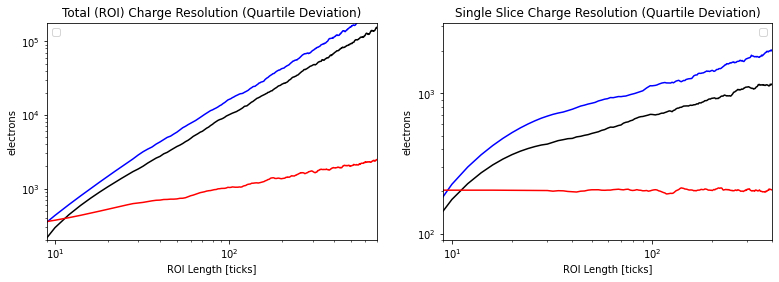

In [11]:
window = 21
order = 3
fig, axes = plt.subplots(1,2,figsize=(13,4))
plt.subplots_adjust(hspace=0.6)
# axes[0].plot(roi_array,roi_quar[0],label="u",color="black")
# axes[0].plot(roi_array,roi_quar[1],label="v",color="blue")
# axes[0].plot(roi_array,roi_quar[2],label="w",color="red")
roi_quar_u_sf = savgol_filter(roi_quar[0], window, order)
roi_quar_v_sf = savgol_filter(roi_quar[1], window, order)
roi_quar_w_sf = savgol_filter(roi_quar[2], window, order)
axes[0].plot(roi_array,roi_quar_u_sf,color="black")
axes[0].plot(roi_array,roi_quar_v_sf,color="blue")
axes[0].plot(roi_array,roi_quar_w_sf,color="red")
axes[0].legend()
axes[0].set_xscale("log")
axes[0].set_yscale("log")
axes[0].set_title("Total (ROI) Charge Resolution (Quartile Deviation)")
axes[0].set_xlabel("ROI Length [ticks]")
axes[0].set_ylabel("electrons")
axes[0].set_xlim(9,700)
axes[0].set_ylim(200,1.8e5)

# axes[1].plot(roi_array,slc_quar[0],label="u",color="black")
# axes[1].plot(roi_array,slc_quar[1],label="v",color="blue")
# axes[1].plot(roi_array,slc_quar[2],label="w",color="red")
slc_quar_u_sf = savgol_filter(slc_quar[0], window, order)
slc_quar_v_sf = savgol_filter(slc_quar[1], window, order)
slc_quar_w_sf = savgol_filter(slc_quar[2], window, order)
axes[1].plot(roi_array,slc_quar_u_sf,color="black")
axes[1].plot(roi_array,slc_quar_v_sf,color="blue")
axes[1].plot(roi_array,slc_quar_w_sf,color="red")
axes[1].legend()
axes[1].set_xscale("log")
axes[1].set_yscale("log")
axes[1].set_title("Single Slice Charge Resolution (Quartile Deviation)")
axes[1].set_xlabel("ROI Length [ticks]")
axes[1].set_ylabel("electrons")
axes[1].set_xlim(9,400)
axes[1].set_ylim(9e1,3.2e3)

plt.show()

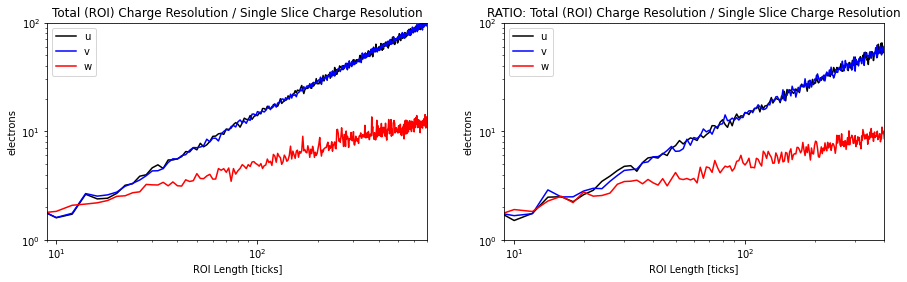

In [12]:
# ratio of total charge resolution to single slice charge resolution
fig, axes = plt.subplots(1,2,figsize=(15,4))
plt.subplots_adjust(hspace=0.6)
axes[0].plot(roi_array,roi_reso[0]/slc_reso[0],label="u",color="black")
axes[0].plot(roi_array,roi_reso[1]/slc_reso[1],label="v",color="blue")
axes[0].plot(roi_array,roi_reso[2]/slc_reso[2],label="w",color="red")
axes[0].legend()
axes[0].set_xscale("log")
axes[0].set_yscale("log")
axes[0].set_title("Total (ROI) Charge Resolution / Single Slice Charge Resolution")
axes[0].set_xlabel("ROI Length [ticks]")
axes[0].set_ylabel("electrons")
axes[0].set_xlim(9,700)
axes[0].set_ylim(1,1e2)

axes[1].plot(roi_array,roi_quar[0]/slc_quar[0],label="u",color="black")
axes[1].plot(roi_array,roi_quar[1]/slc_quar[1],label="v",color="blue")
axes[1].plot(roi_array,roi_quar[2]/slc_quar[2],label="w",color="red")
axes[1].legend()
axes[1].set_xscale("log")
axes[1].set_yscale("log")
axes[1].set_title("RATIO: Total (ROI) Charge Resolution / Single Slice Charge Resolution")
axes[1].set_xlabel("ROI Length [ticks]")
axes[1].set_ylabel("electrons")
axes[1].set_xlim(9,400)
axes[1].set_ylim(1,1e2)

plt.show()